In [9]:
from networkx.algorithms.non_randomness import non_randomness
from torch_staintools.normalizer import NormalizerBuilder
from torchvision.datasets import ImageFolder


"""
Zuerst stellen wir sicher, dass die notwendigen Pakete installiert sind und importieren diese:
"""
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms.autoaugment import AutoAugmentPolicy
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score



import os
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()

In [10]:
"""
Random Seet setzen, damit Ergebnisse reproduzierbar sind
"""

import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

set_seed(42)

g = torch.Generator()
g.manual_seed(42)


In [ ]:
#import Augmentor

#normalized_dir = "./AugmentedData/Train/"

#for root, dirs, files in os.walk(normalized_dir):
#    for dir in dirs:


#p = Augmentor.Pipeline(normalized_dir)
#p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
#p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
#p.resize(probability=1.0, width=224, height=224)
#p.sample(500)  # Generates 500 augmented images

#augmentor_transform = p.torch_transform()

In [13]:
"""
Nun definieren wir Transformatoren für die Daten, laden das Dataset und teilen diese in Trainings- und Validierungsätze auf:
"""
# Definieren Sie Transformationen für das Training und die Validierung
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),

        #transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406],
                             #[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406],
                            #[0.229, 0.224, 0.225])
    ])
}

train_dataset = torchvision.datasets.ImageFolder(root='AugmentedData/Train', transform=transform["train"])
test_dataset = torchvision.datasets.ImageFolder(root='AugmentedData/Test', transform=transform["test"])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True, generator=g, worker_init_fn=seed_worker)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True, generator=g, worker_init_fn=seed_worker)

/Users/jakobmerten/uni/ai/Cancer_Data_Collection/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


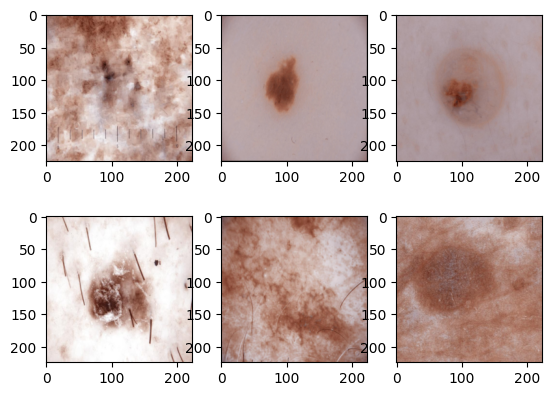

In [14]:
# look at one batch of images
examples = iter(train_loader) # create iterable object
samples, labels = next(examples)  # unpack the batch
# make a plot
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow((samples[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8))
plt.show()

In [15]:
# Device configuration, Prüfe ob GPU verfügbar ist, falls ja, lasse das Modell auf eie GPU laufen, ansonsten CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Wähle ein Modell aus unter: https://pytorch.org/vision/main/models.html
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)


# mit diesem Code snippet können wir die Parmeter freeze, sodass diese nicht gelernt werden. Ziel Wir trainieren nur den letzten layer, den wir am Ende hinzufügen.
"""
# freeze all model parameters
for param in model.parameters():
    param.requires_grad = False
"""
#num_ftrs = model.heads[0].in_features
#model.heads[0] = torch.nn.Linear(num_ftrs, len(train_dataset.classes))



model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
"""
Trainieren des Modells
"""
# Trainingsschleife
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    pbar = tqdm(train_loader)
    nr_samples = 0
    labels_global = []
    preds_global = []
    for idx, (images, labels) in enumerate(pbar, start=1):
        # Vorhersage und Verlust berechnen
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Gradienten zurücksetzen, Backwardpropagation und Optimierung
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        nr_samples += images.shape[0]
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels)
        labels_global.extend(labels.tolist())
        preds_global.extend(preds.tolist())
        cnt_acc = running_corrects/nr_samples
        cnt_loss = running_loss/nr_samples
        f1 = f1_score(labels_global, preds_global, average='micro')
        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {cnt_loss:.3f}, Acc: {cnt_acc:.3f}, F1-Score: {f1:.3f}')


  0%|          | 0/35 [00:00<?, ?it/s]

In [8]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
errors = []
model.eval()
running_corrects = 0
nr_samples = 0
for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs.data, 1)
    running_corrects += torch.sum(preds == labels)
    nr_samples += images.shape[0]
    if preds != labels:
      errors.append({"image":images.to("cpu")[0], "y_hat":preds.to("cpu")[0].item(), "label":labels.to("cpu")[0].item()})
print()
print(f"Accuracy on Test dataset: {(running_corrects/nr_samples)*100:.3f} %")

100%|██████████| 118/118 [00:11<00:00, 10.02it/s]


Accuracy on Test dataset: 38.983 %


Label: 0, Prediction: 4


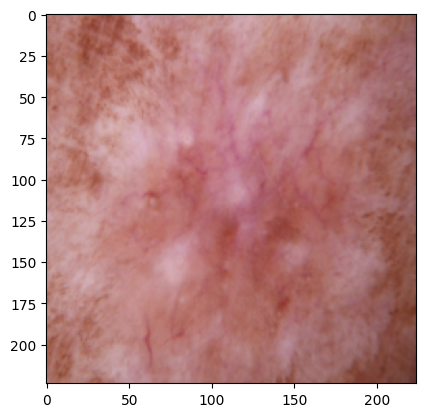

In [35]:
idx = 3
print(f"Label: {errors[idx]['label']}, Prediction: {errors[idx]['y_hat']}")
plt.imshow((errors[idx]['image'].permute(1, 2, 0).numpy() * 255).astype(np.uint8))
plt.show()